In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn.manifold import TSNE

In [3]:
data = pd.read_csv('~/Desktop/columbia/capstone/fire-regimes/data/merged_output.csv').drop(columns=['id1','id2','time','x','y'])

df_dedup = data.groupby(['source_file','level'], as_index=False).mean()
df_pivoted = df_dedup.set_index(['source_file', 'level']).unstack('level')
df_pivoted.columns = [f'{level}-{var}' for var, level in df_pivoted.columns]

X = df_pivoted[~np.isnan(df_pivoted).any(axis=1)]

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [5]:
pca = decomposition.PCA(n_components=16)
pca.fit(X)
x_pca = pca.transform(X)

In [6]:
random_indices = np.random.choice(x_pca.shape[0], size=500, replace=False)
X_sample = x_pca[random_indices].round(4)

# tsne = TSNE(n_components=2, random_state=1)
# X_tsne = tsne.fit_transform(X_sample)

# plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

# plt.figure(figsize=(8, 6))
# plt.show()

In [7]:
tsne = TSNE(n_components=2, random_state=1)
X_tsne = tsne.fit_transform(X_sample[:1000,:15])

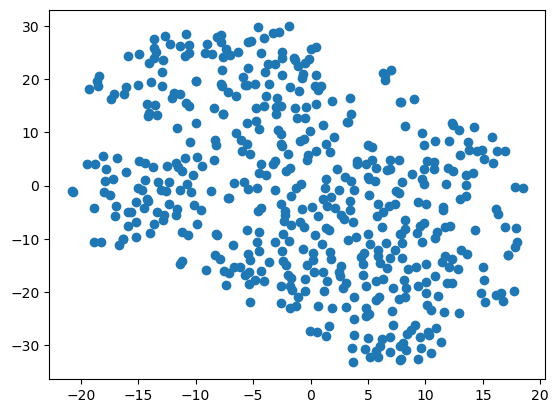

In [8]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

In [112]:
train_data = torch.from_numpy(X).float()
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=64, shuffle=True)

In [99]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(174,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,12)
        )
         
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(12, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 174)
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [113]:
model = AE()
 
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
 
#Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.1,
                             weight_decay = 1e-8)

In [119]:
epochs = 5
outputs = []
losses = []

for epoch in range(epochs):
  for profile in train_loader:
       
    # Output of Autoencoder
    reconstructed = model(profile)
      
    # Calculating the loss function
    loss = loss_function(reconstructed, profile)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
      
    # Storing the losses in a list for plotting
    losses.append(loss)
    outputs.append((epochs, profile, reconstructed))

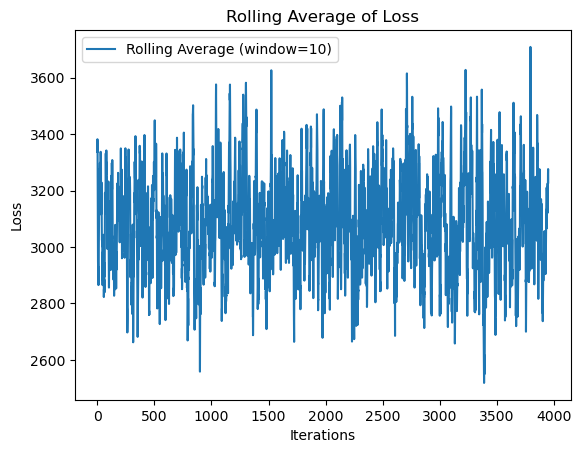

In [121]:
loss_floats = [loss.item() for loss in losses]

def rolling_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Set the rolling window size (e.g., 10)
window_size = 10
smoothed_losses = rolling_average(loss_floats, window_size)

# Plotting the smoothed loss values
plt.plot(smoothed_losses, label=f'Rolling Average (window={window_size})')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Rolling Average of Loss')
plt.legend()
plt.show()


In [85]:
r = reconstructed.detach().numpy()
p = profile.detach().numpy()

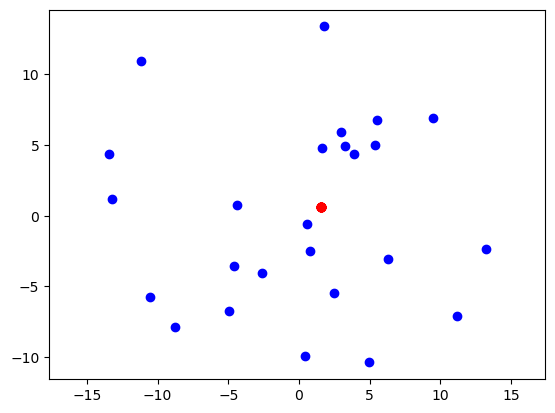

In [72]:
pca = decomposition.PCA(n_components=2)
pca.fit(p)
p = pca.transform(p)
r = pca.transform(r)

plt.scatter(p[:,0], p[:,1], color='blue', marker='o')
plt.scatter(r[:,0], r[:,1], color='red', marker='o')
plt.axis('equal')
plt.show()

In [ ]:
latent_space = model.encoder(train_data).detach().numpy()

tsne = TSNE(n_components=2, random_state=1)
X_tsne = tsne.fit_transform(latent_space[:1000,:])

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

In [76]:
r = model(train_data)